To do: must make it more adaptable to changes between odd vs even num of threads.

In [17]:
from PIL import Image, ImageDraw, ImageOps
import numpy as np

OVAL_RADIUS=20
LINE_THICKNESS=10
KNOT_HORIZ_SPACING=3*OVAL_RADIUS
KNOT_VERT_SPACING=int(KNOT_HORIZ_SPACING/2)-(OVAL_RADIUS)
HORIZ_MARGIN=80
VERT_MARGIN=40

black_arrows=[Image.open("Icons\FWD_B.png").convert("RGBA").resize((OVAL_RADIUS, OVAL_RADIUS)),
              Image.open("Icons\BWD_B.png").convert("RGBA").resize((OVAL_RADIUS, OVAL_RADIUS)),
              Image.open("Icons\FWDBWD_B.png").convert("RGBA").resize((OVAL_RADIUS, OVAL_RADIUS)),
              Image.open("Icons\BWDFWD_B.png").convert("RGBA").resize((OVAL_RADIUS, OVAL_RADIUS))]

white_arrows=[Image.open("Icons\FWD_W.png").convert("RGBA").resize((OVAL_RADIUS, OVAL_RADIUS)),
              Image.open("Icons\BWD_W.png").convert("RGBA").resize((OVAL_RADIUS, OVAL_RADIUS)),
              Image.open("Icons\FWDBWD_W.png").convert("RGBA").resize((OVAL_RADIUS, OVAL_RADIUS)),
              Image.open("Icons\BWDFWD_W.png").convert("RGBA").resize((OVAL_RADIUS, OVAL_RADIUS))]


def get_color_appropriate_arrow(arrow_index, color_hex):
    color_hex=color_hex.lstrip('#')

    r = int(color_hex[0:2], 16)
    g = int(color_hex[2:4], 16)
    b = int(color_hex[4:6], 16)

    luminance = (0.299 * r + 0.587 * g + 0.114 * b) / 255

    if(luminance<0.5): # if dark
        return white_arrows[arrow_index]
    else:
        return black_arrows[arrow_index]
    

def get_knot_result(arrow_index, left_color, right_color):
    knot_color=None
    left_out_color=None
    right_out_color=None

    if(arrow_index==0 or arrow_index==2): # fwd or fwdbwd
        knot_color=left_color
    else: # bwd or bwdfwd
        knot_color=right_color


    if(arrow_index==0 or arrow_index==1): # fwd or bwd
        left_out_color=right_color
        right_out_color=left_color
    else: # fwdbwd or bwdfwrd
        left_out_color=left_color
        right_out_color=right_color

    return knot_color, left_out_color, right_out_color


- FWD: 0
- BWD: 1
- FWDBWD: 2
- BWDFWD: 3
- NO KNOT: -1

# Threads Array Generation

In [18]:
#############################
# For testing
#############################

knots_array=[[0, 1, 1, 3],
             [0, 0, 0,0],
             [3, 2, 2, 0],
             [0, 0, 0,0]]

initial_threads=['#ffff00', '#ff0000', '#0000ff', '#ff0000','#ff0000','#ff0000','#ff0000','#ffff00','#ff0000']

def get_threads_array(knots_arr, initial_threads):
    threads_arr=[initial_threads]

    num_rows=len(knots_arr)
    num_threads=len(threads_arr[0])
    num_cols=int(np.floor(float(num_threads)/2))

    ##############################

    for row in range(num_rows):
        threads_row=threads_arr[-1]
        new_threads_row=[]
        if(row%2!=0): # if row is odd
            new_threads_row.append(threads_row[0])

        for col in range(num_cols):
            if(row%2==0): # if row is even
                left_in=threads_row[col*2]
                right_in=threads_row[(col*2)+1]
            else: # if row is odd
                if(num_threads%2==0 and col==num_cols-1): # if num of threads is even and we reached end of row
                    new_threads_row.append(threads_row[-1])
                    continue # no knot
                left_in=threads_row[(col*2)+1]
                right_in=threads_row[(col*2)+2]
            color_hex, left_out, right_out =get_knot_result(knots_arr[row][col],left_in, right_in)

            new_threads_row.append(left_out)
            new_threads_row.append(right_out)
        if(num_threads%2!=0 and row%2==0):
            new_threads_row.append(threads_row[-1])
        threads_arr.append(new_threads_row)
    return threads_arr

threads_array=get_threads_array(knots_array, initial_threads)


# Visualization

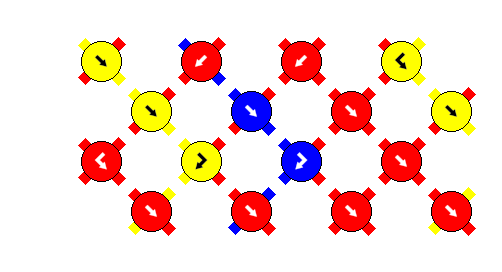

In [19]:
def display_diagram(knots_arr, threads_arr):
    num_rows=len(knots_arr)
    num_threads=len(threads_arr[0])
    num_cols=int(np.floor(float(num_threads)/2))
    
    # Initializing the base image
    image_width=HORIZ_MARGIN*2+(num_cols*OVAL_RADIUS*2)+((num_cols-1)*KNOT_HORIZ_SPACING)
    image_height=VERT_MARGIN*2+(num_rows*OVAL_RADIUS*2)+((num_rows-1)*KNOT_VERT_SPACING)

    image = Image.new('RGBA',(image_width, image_height))

    draw = ImageDraw.Draw(image)

    for row in range(num_rows):
        threads_row=threads_arr[row]

        for col in range(num_cols):

            if(row%2==0): # if row is even
                oval_x_start=int(HORIZ_MARGIN+(2*col*OVAL_RADIUS)+(col*KNOT_HORIZ_SPACING))
                left_in=threads_arr[row][col*2]
                right_in=threads_arr[row][(col*2)+1]
            else: # if row is odd
                oval_x_start=int((OVAL_RADIUS)+(KNOT_HORIZ_SPACING/2)+HORIZ_MARGIN+(2*col*OVAL_RADIUS)+(col*KNOT_HORIZ_SPACING))
                if(num_threads%2==0 and col==num_cols-1): # if num of threads is even and we reached end of row
                    continue # no knot
                left_in=threads_arr[row][(col*2)+1]
                right_in=threads_arr[row][(col*2)+2]
            
            oval_y_start=int(VERT_MARGIN+(2*row*OVAL_RADIUS)+(row*KNOT_VERT_SPACING))
            
            color_hex, left_out, right_out =get_knot_result(knots_arr[row][col],left_in, right_in)

            draw.line([(oval_x_start,oval_y_start),(oval_x_start+OVAL_RADIUS,oval_y_start+OVAL_RADIUS)], fill=left_in, width=LINE_THICKNESS)
            draw.line([(oval_x_start+(2*OVAL_RADIUS),oval_y_start),(oval_x_start+OVAL_RADIUS,oval_y_start+OVAL_RADIUS)], fill=right_in, width=LINE_THICKNESS)
            draw.line([(oval_x_start+OVAL_RADIUS,oval_y_start+OVAL_RADIUS),(oval_x_start+(2*OVAL_RADIUS),oval_y_start+(2*OVAL_RADIUS))], fill=right_out, width=LINE_THICKNESS)
            draw.line([(oval_x_start+OVAL_RADIUS,oval_y_start+OVAL_RADIUS),(oval_x_start,oval_y_start+(2*OVAL_RADIUS))], fill=left_out, width=LINE_THICKNESS)
            
            arrow=get_color_appropriate_arrow(knots_arr[row][col], color_hex=color_hex)
            draw.ellipse((oval_x_start, oval_y_start, oval_x_start+OVAL_RADIUS*2, oval_y_start+OVAL_RADIUS*2), fill = color_hex, outline='black')
            
            image.paste(arrow, (oval_x_start+int(OVAL_RADIUS/2), oval_y_start+int(OVAL_RADIUS/2)),arrow)

    image=ImageOps.expand(image, border=1, fill='white')
    display(image)

display_diagram(knots_array, threads_array)


[['#ffff00', '#ff0000', '#0000ff', '#ff0000', '#ff0000', '#ff0000', '#ff0000', '#ffff00', '#ff0000'], ['#ff0000', '#ffff00', '#ff0000', '#0000ff', '#ff0000', '#ff0000', '#ff0000', '#ffff00', '#ff0000']]
[['#ffff00', '#ff0000', '#0000ff', '#ff0000', '#ff0000', '#ff0000', '#ff0000', '#ffff00', '#ff0000'], ['#ff0000', '#ffff00', '#ff0000', '#0000ff', '#ff0000', '#ff0000', '#ff0000', '#ffff00', '#ff0000'], ['#ff0000', '#ff0000', '#ffff00', '#ff0000', '#0000ff', '#ff0000', '#ff0000', '#ff0000', '#ffff00']]
[['#ffff00', '#ff0000', '#0000ff', '#ff0000', '#ff0000', '#ff0000', '#ff0000', '#ffff00', '#ff0000'], ['#ff0000', '#ffff00', '#ff0000', '#0000ff', '#ff0000', '#ff0000', '#ff0000', '#ffff00', '#ff0000'], ['#ff0000', '#ff0000', '#ffff00', '#ff0000', '#0000ff', '#ff0000', '#ff0000', '#ff0000', '#ffff00'], ['#ff0000', '#ff0000', '#ffff00', '#ff0000', '#0000ff', '#ff0000', '#ff0000', '#ff0000', '#ffff00']]
[['#ffff00', '#ff0000', '#0000ff', '#ff0000', '#ff0000', '#ff0000', '#ff0000', '#ffff00'

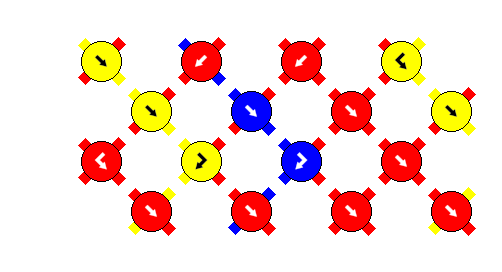

In [20]:
class Knot:
    def __init__(self, row, col, knot_type, left_in, right_in):
        self.row = row
        self.col = col
        self.knot_type = knot_type
        self.left_in = left_in
        self.right_in = right_in
        self.input_colors = [left_in, right_in]
        self.get_knot_result()
        self.output_colors = [self.left_out, self.right_out]

    def get_knot_result(self):
        self.knot_color=None
        self.left_out=None
        self.right_out=None

        if(self.knot_type==0 or self.knot_type==2): # fwd or fwdbwd
            self.knot_color=self.left_in
        else: # bwd or bwdfwd
            self.knot_color=self.right_in


        if(self.knot_type==0 or self.knot_type==1): # fwd or bwd
            self.left_out=self.right_in
            self.right_out=self.left_in
        else: # fwdbwd or bwdfwrd
            self.left_out=self.left_in
            self.right_out=self.right_in
    def involves_color(self, color):
        return color in self.input_colors

class Bracelet:
    def __init__(self, initial_threads):
        self.threads=[initial_threads]
        self.num_threads=len(self.threads[0])
        self.symmetric=self.num_threads%2==0
        self.knots_array=[]
        self.num_rows=0
        self.num_cols=int(np.floor(float(self.num_threads)/2))
    
        '''    def get_left_parent(self, current_knot):
        if(self.symmetric):
            if(current_knot.row%2==0): # if row of knot is even

            else:
        else:
            if(current_knot.row%2==0): # if row of knot is even
            else:'''

    def add_knots_row(self, knot_types):
        knots_row=[]
        new_threads_row=[]
        new_row=self.num_rows

        if(new_row%2!=0): # new row is odd
            new_threads_row.append(self.threads[-1][0])

        for new_col, knot_t in enumerate(knot_types):
            if(new_row%2==0): # row is even
                left_in=self.threads[-1][2*new_col]
                right_in=self.threads[-1][(2*new_col)+1]
            else: # row is odd
                left_in=self.threads[-1][(2*new_col)+1]
                right_in=self.threads[-1][(2*new_col)+2]
            
            knots_row.append(Knot(new_row, new_col,knot_t,left_in, right_in))
            
            new_threads_row.append(knots_row[-1].left_out)
            new_threads_row.append(knots_row[-1].right_out)

        if((self.symmetric and new_row%2!=0) or (not self.symmetric and new_row%2==0)):
            new_threads_row.append(self.threads[-1][-1])  
              
        self.knots_array.append(knots_row)
        self.threads.append(new_threads_row)
        self.num_rows+=1
        print(self.threads)

    def display(self):
        # Initializing the base image
        image_width=HORIZ_MARGIN*2+(self.num_cols*OVAL_RADIUS*2)+((self.num_cols-1)*KNOT_HORIZ_SPACING)
        image_height=VERT_MARGIN*2+(self.num_rows*OVAL_RADIUS*2)+((self.num_rows-1)*KNOT_VERT_SPACING)

        image = Image.new('RGBA',(image_width, image_height))

        draw = ImageDraw.Draw(image)

        for row in range(self.num_rows):
            threads_row=self.threads[row]

            for col in range(self.num_cols):

                if(row%2==0): # if row is even
                    oval_x_start=int(HORIZ_MARGIN+(2*col*OVAL_RADIUS)+(col*KNOT_HORIZ_SPACING))
                    left_in=self.threads[row][col*2]
                    right_in=self.threads[row][(col*2)+1]
                else: # if row is odd
                    oval_x_start=int((OVAL_RADIUS)+(KNOT_HORIZ_SPACING/2)+HORIZ_MARGIN+(2*col*OVAL_RADIUS)+(col*KNOT_HORIZ_SPACING))
                    if(self.num_threads%2==0 and col==self.num_cols-1): # if num of threads is even and we reached end of row
                        continue # no knot
                    left_in=self.threads[row][(col*2)+1]
                    right_in=self.threads[row][(col*2)+2]
                
                oval_y_start=int(VERT_MARGIN+(2*row*OVAL_RADIUS)+(row*KNOT_VERT_SPACING))
                
                color_hex=self.knots_array[row][col].knot_color
                left_out=self.knots_array[row][col].left_out
                right_out=self.knots_array[row][col].right_out

                draw.line([(oval_x_start,oval_y_start),(oval_x_start+OVAL_RADIUS,oval_y_start+OVAL_RADIUS)], fill=left_in, width=LINE_THICKNESS)
                draw.line([(oval_x_start+(2*OVAL_RADIUS),oval_y_start),(oval_x_start+OVAL_RADIUS,oval_y_start+OVAL_RADIUS)], fill=right_in, width=LINE_THICKNESS)
                draw.line([(oval_x_start+OVAL_RADIUS,oval_y_start+OVAL_RADIUS),(oval_x_start+(2*OVAL_RADIUS),oval_y_start+(2*OVAL_RADIUS))], fill=right_out, width=LINE_THICKNESS)
                draw.line([(oval_x_start+OVAL_RADIUS,oval_y_start+OVAL_RADIUS),(oval_x_start,oval_y_start+(2*OVAL_RADIUS))], fill=left_out, width=LINE_THICKNESS)
                
                arrow=get_color_appropriate_arrow(self.knots_array[row][col].knot_type, color_hex=color_hex)
                draw.ellipse((oval_x_start, oval_y_start, oval_x_start+OVAL_RADIUS*2, oval_y_start+OVAL_RADIUS*2), fill = color_hex, outline='black')
                
                image.paste(arrow, (oval_x_start+int(OVAL_RADIUS/2), oval_y_start+int(OVAL_RADIUS/2)),arrow)

        image=ImageOps.expand(image, border=1, fill='white')
        display(image)
bracelet=Bracelet(initial_threads)
for k_row in knots_array:
    bracelet.add_knots_row(k_row)
bracelet.display()


In [21]:
# This code is from chatGPT (I'm only human after all)
from itertools import product

# Generate all combinations of distributing 'extra' threads among colors
# This is equivalent to integer compositions of 'extra' into len(colors) parts
def generate_extra_combinations(n, k):
    if k == 1:
        yield (n,)
    else:
        for i in range(n + 1):
            for tail in generate_extra_combinations(n - i, k - 1):
                yield (i,) + tail

In [ ]:
class Thread:
    def __init__(self, possibilities):
        self.locked=False
        self.possibilities=possibilities
        self.final_value = None
    def remove_possibility(self, possibility):
        if(possibility in self.possibilities):
            self.possibilities.remove(possibility)
        return self.updateState()
    def remove_possibility_by_idx(self, idx):
        self.possibilities.pop(idx)
        return self.updateState()
    def updateState(self):
        if(len(self.possibilities)==1):
            self.final_value=self.possibilities[0]
            return 1
        elif(len(self.possibilities)<1):
            return -1
        else:
            return len(self.possibilities)
    def lock(self):
        self.locked=True

class ThreadsGrid:
    def __init__(self, num_threads, colors):
        self.num_rows=0
        self.num_threads=num_threads
        self.colors=colors
        self.rows=[]

    def add_row(self):
        new_row=[]
        for i in range(self.num_threads):
            new_row.append(Thread(possibilities=self.colors))
        self.rows.append(new_row)
        self.num_rows+=1

class Solver:
    def __init__(self, target_design):
        self.target_design=target_design
        # figure out colors
        self.colors=set(target_design[0])
        for row in target_design:
            self.colors.update(row)
        self.colors=list(self.colors)

        # figure out num of rows needed
        self.num_rows=len(target_design+1)

        # figure out num of threads needed
        self.num_threads=int(np.floor(len(target_design[0])/2))
        if(len(target_design[0])==len(target_design[1])): # if number of knots is constant across rows, num of threads must be odd
            self.num_threads+=1
        
        self.symmetric=False
        if(self.num_threads%2==0):
            self.symmetric=True

        # instantiate ThreadsGrid
        self.threads_grid = ThreadsGrid(self.num_threads, self.colors)

        for i in range(self.num_rows):
            self.threads_grid.add_row()

        # locking left side
        for i in range(self.num_rows):
            if(i%2!=0):
                self.threads_grid[i][0].lock()
            
        # locking right side
        for i in range(self.num_rows):
            if((self.symmetric and i%2!=0) or (not self.symmetric and i%2==0)):
                self.threads_grid[i][-1].lock()
        
        # calculate possible color combos
        self.color_combos=self.get_color_combos()

    def get_color_combos(self):
        min_threads_per_color={}
        min_threads_per_color_sum=0
        # for each color, you need a minimum number of threads of n, where n is the max num of knots in that color in the same row
        for c in self.colors:
            c_max_knots=0
            for row in self.target_design:
                # count num of knots of that color in that row
                n_knots=0
                for knot in row:
                    if(knot==c):
                        n_knots+=1
                if(n_knots>c_max_knots):
                    c_max_knots=n_knots
            min_threads_per_color[c]=c_max_knots
            min_threads_per_color_sum+=c_max_knots

        # if sum of min threads per color is more than num of threads, solution is impossible
        if(min_threads_per_color_sum>self.num_threads):
            raise Exception("No possible solution")
        elif(min_threads_per_color_sum==self.num_threads):
            return [min_threads_per_color]
        else:
            combos=[]
            DoF = self.num_threads-min_threads_per_color_sum # Degrees of Freedom: number of threads that can be any color
            mins = list(min_threads_per_color.values())

            for extra_combo in generate_extra_combinations(DoF, len(self.colors)):
                dist = {color: mins[i] + extra_combo[i] for i, color in enumerate(self.colors)}
                combos.append(dist)
            
            return combos
    
    def get_goal_color(self, row, col):
        row=row%self.num_rows # because first row will be repeated and might cause index out of range error
        if(row%2==0): # even row
            return self.target_design[row][int(np.floor(col/2))]
        else:
            return self.target_design[row][int(np.floor((col-1)/2))]
        
    def update_possibilities(self, threads_per_color_dict): # according to the 5 rules
        # 1. Num of threads per color should be constant across rows
        for row in self.threads_grid.rows:
            for c in self.colors:
                # count that color in that row
                color_ctr=0
                for thread in row:
                    if(thread.final_value==c):
                        color_ctr+=1
                if(color_ctr==threads_per_color_dict[c]):
                    # remove that color's possibility from other threads
                    for thread in row:
                        removal_result=thread.remove_possibility(c)
                        if(removal_result==-1):
                            raise Exception("No possible solution")

        # 2. At least one of the two threads before the knot should have the goal color of that knot
        # 3. Locked threads should have the same color as itself in the next row
        # 4. Moving pairs can either switch or stay in place
        # 5. Final threads should be the exact same as the initial threads